In [1]:
from typing import List, Tuple

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import Generator
import seaborn as sns
import sys
sys.path.append("../")
import util
import importlib
importlib.reload(util)

from util import util_functions
from util.util_functions import PreprocessInfo
from util.util_functions import ClusteringExperiment

px = 1/plt.rcParams["figure.dpi"]
plt.rcParams['figure.figsize'] = [1848*px, 965*px]
c = [
    "#007fff",  # Blue
    "#ff3616",  # Red
    "#138d75",  # Green
    "#7d3c98",  # Purple
    "#fbea6a",  # Yellow
]
sns.set(
    style="ticks",
    rc={
        "font.family": "Arial",
        "font.size": 40,
        "axes.linewidth": 2,
        "lines.linewidth": 5,
    },
    font_scale=2.5,
    palette=sns.color_palette("Set2")
)

CONDUCTANCE_LABEL = r"Conductance (log$_{10}$(G/G$_0$))"
ALPHABET = "ABCDEFGHIJKLMNOPQ"
RNG_STATE = 43
FONTSIZE = 48

In [2]:
traces = np.genfromtxt("./Ferrocene_Pull_Conductance.txt", skip_header=2)
traces = traces.T

blanks = np.genfromtxt("./Clean_Au_Pull_Conductance.txt", skip_header=2)
blanks = blanks.T

In [3]:
hist2d_length = 1024 + 256
pre_info = PreprocessInfo(
    high=-.5,
    low=-5.3,
    plot_high=-.5,
    plot_low=-5.3,
    bins=100,
    bins_2d=(16, 16),
    hist2d_length=hist2d_length,
)

In [4]:
p_blanks, fullwindow_blanks = util_functions.rt_preprocessing(blanks, pre_info, longest_cutoff=6_000, apply_log=True)
p_molecular, fullwindow_molecular = util_functions.rt_preprocessing(traces, pre_info, longest_cutoff=6_000, apply_log=True)

hist_blanks, hist_blanks2d = util_functions.get_histograms(
    p_blanks, low=pre_info.low, high=pre_info.high, pre_info=pre_info
)
hist_molecular, hist_molecular2d = util_functions.get_histograms(
    p_molecular, low=pre_info.low, high=pre_info.high, pre_info=pre_info
)

plot_hist_blanks, plot_hist_blanks2d = util_functions.get_histograms(
    fullwindow_blanks, low=pre_info.plot_low, high=pre_info.plot_high, pre_info=pre_info
)
plot_hist_molecular, plot_hist_molecular2d = util_functions.get_histograms(
    fullwindow_molecular, low=pre_info.plot_low, high=pre_info.plot_high, pre_info=pre_info
)

100%|██████████| 8720/8720 [00:01<00:00, 6360.72it/s]


Amount discarded: 804


100%|██████████| 6410/6410 [00:00<00:00, 8630.12it/s]


Amount discarded: 243


Generating 1D- and 2D histograms: 100%|██████████| 6167/6167 [00:01<00:00, 3763.13it/s]


In [5]:
print(f"Amount of blank traces: {len(p_blanks)}")
print(f"Amount of molecular traces: {len(p_molecular)}")

Amount of blank traces: 7916
Amount of molecular traces: 6167


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


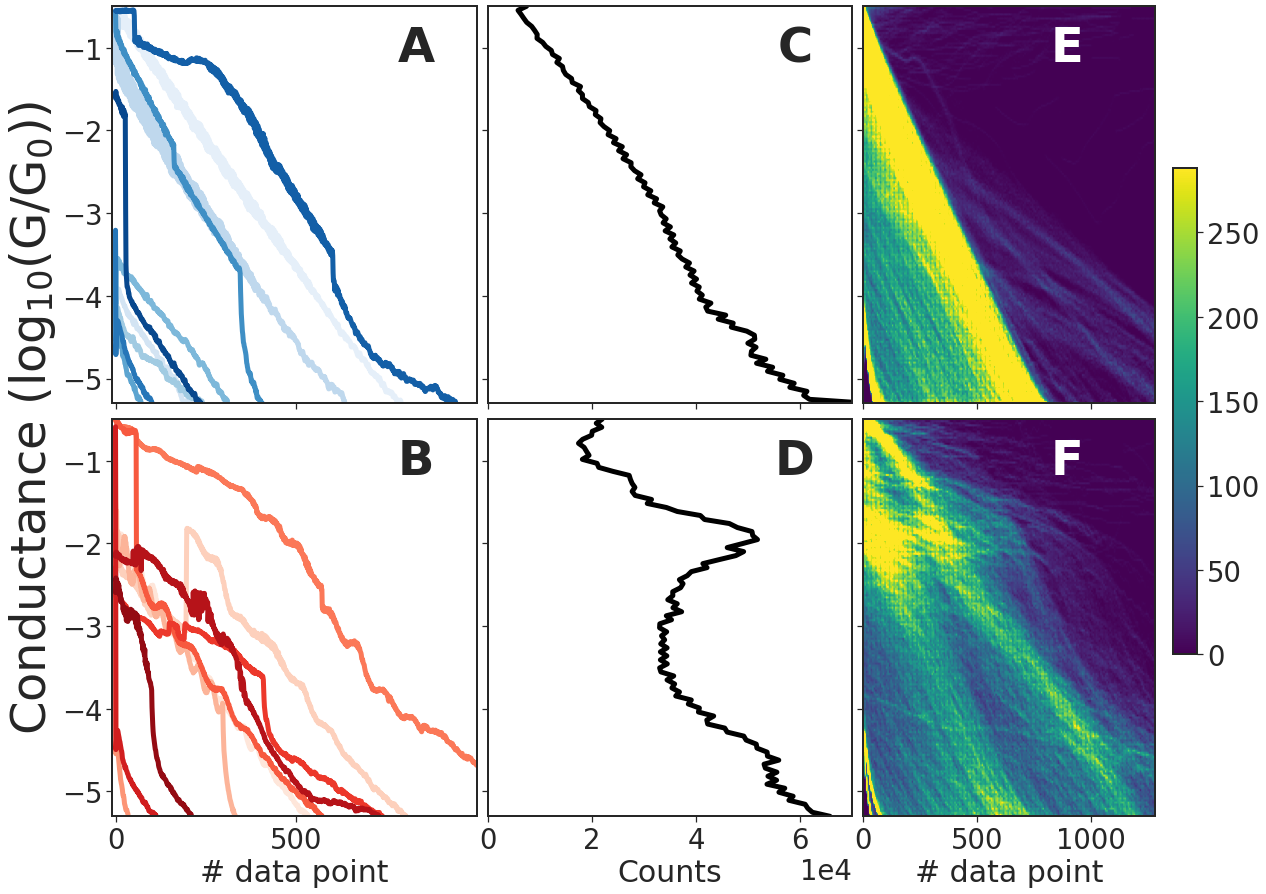

In [6]:
rng = np.random.default_rng(seed=RNG_STATE)
text_height = -1.
amount_traces = 10
blues = sns.color_palette("Blues", amount_traces)
reds = sns.color_palette("Reds", amount_traces)
colors = [blues, reds]

# Visualization of both parts of the data set
fig, ax = plt.subplots(2, 3, figsize=(20, 30))
for idx, (dataset_hists, dataset_traces) in enumerate(
    [
        [plot_hist_blanks, fullwindow_blanks],
        [plot_hist_molecular, fullwindow_molecular],
    ]
):
    max_length = 0
    for c_i, trace in enumerate(dataset_traces[rng.integers(low=0, high=len(dataset_traces), size=amount_traces, endpoint=True)]):
        ax[idx, 0].plot(trace, c=colors[idx][c_i])
        if len(trace) > max_length:
            max_length = len(trace)
    ax[idx, 0].set_ylim(pre_info.plot_low, pre_info.plot_high)
    ax[idx, 0].set_xlim(-10, 999)
    ax[idx, 0].text(1024 - 128 - 64, text_height, ALPHABET[idx], va="center", ha="center", weight="bold", size=FONTSIZE)
    
    plot_hists = dataset_hists.sum(axis=0)
    ax[idx, 1].plot(
        plot_hists, np.linspace(pre_info.plot_low, pre_info.plot_high, dataset_hists.shape[1]), c="k"
    )
    ax[idx, 1].set_xlim(0, 7e4)
    ax[idx, 1].set_ylim(pre_info.plot_low, pre_info.plot_high)
    ax[idx, 1].text(5.9e4, text_height, ALPHABET[idx + 2], va="center", ha="center", weight="bold", size=FONTSIZE)

    bins_2d = 128 + 64
    hist_2d = np.zeros((bins_2d, bins_2d))
    for trace in dataset_traces:
        H, *_ = np.histogram2d(
            trace, np.arange(len(trace)), bins=bins_2d, range=[[pre_info.plot_low, pre_info.plot_high], [0, hist2d_length]]
        )
        hist_2d += H

    vmax = 256 + 32
    im = ax[idx, 2].imshow(
        hist_2d, vmin=0, vmax=vmax, origin="lower", cmap="viridis", extent=[0, hist2d_length, pre_info.plot_low, pre_info.plot_high], aspect="auto"
    )
    ax[idx, 2].text(
        512 + 256 + 128, text_height, ALPHABET[idx + 4], va="center", ha="center", weight="bold", size=FONTSIZE, c="white"
    )

    if idx == 0:
        ax[idx, 0].set_xticklabels([])
        ax[idx, 1].set_xticklabels([])
        ax[idx, 2].set_xticklabels([])

    ax[idx, 1].set_yticklabels([])
    ax[idx, 2].set_yticklabels([])
    if idx == 1:
        ax[idx, 0].set_xlabel("# data point")
        ax[idx, 1].set_xlabel("Counts")
        ax[idx, 2].set_xlabel("# data point")
        ax[idx, 1].ticklabel_format(axis="x", scilimits=[-5, 4])

fig.text(0.07, 0.31, CONDUCTANCE_LABEL, va="center", ha="center", rotation="vertical", fontsize=FONTSIZE)
fig.subplots_adjust(wspace=0.03, top=0.5, hspace=0.04)
fig.colorbar(im, ax=ax[:, 2], shrink=.6)
fig.savefig("hists.pdf")
plt.show()

In [6]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklego.mixture import GMMOutlierDetector
# from pyod.models.auto_encoder import AutoEncoder
# from pyod.models.deep_svdd import DeepSVDD
# from pyod.models.vae import VAE

model_ocsvm_rbf = OneClassSVM(kernel="rbf", nu=0.01, gamma="scale")
model_ocsvm_linear = OneClassSVM(kernel="linear", nu=0.01)
model_iso = IsolationForest(contamination=0.01)
model_gmm_1comp = GMMOutlierDetector(n_components=1, threshold=0.99, random_state=RNG_STATE)
# model_gmm_16comp_diag = GMMOutlierDetector(n_components=16, threshold=0.99, random_state=RNG_STATE, covariance_type="diag")
model_gmm_3comp = GMMOutlierDetector(n_components=3, threshold=0.99, random_state=RNG_STATE)
model_gmm_8comp = GMMOutlierDetector(n_components=8, threshold=0.99, random_state=RNG_STATE)

# deep learning models
# epochs = 16
# model_simple_ae = AutoEncoder(epochs=epochs, hidden_activation="relu", contamination=0.01, random_state=RNG_STATE)
# model_deepsvdd = DeepSVDD(use_ae=True, epochs=epochs, hidden_activation="relu", contamination=0.01, random_state=RNG_STATE)
# model_deepsvdd_noae = DeepSVDD(use_ae=False, epochs=epochs, hidden_activation="relu", contamination=0.01, random_state=RNG_STATE)
# model_vae = VAE(epochs=epochs, gamma=0.8, hidden_activation="relu", contamination=0.01, random_state=RNG_STATE)

models = [
    model_ocsvm_linear,
    model_ocsvm_rbf,
    # model_iso,
    model_gmm_1comp,
    # model_gmm_16comp_diag,
    model_gmm_3comp,
    # # model_gmm_8comp,
    
    # model_simple_ae,
    # model_deepsvdd,
    # model_deepsvdd_noae,
    # model_vae,
]

names = [
    "OC-SVM (RBF)",
    "OC-SVM (Linear)",
    # "Iso. forest",
    "GMM (1 comp.)",
    # "GMM (x comp. - Diagonal)"
    "GMM (3 comp.)",
    # # "GMM (8 comp.)",

    # "Simple AE",
    # "Deep SVDD",
    # "Deep SVDD (No pretraining)",
    # "VAE",
]

In [7]:
features_blanks = hist_blanks
features_molecular = hist_molecular

# features_blanks = hist_blanks2d
# features_molecular = hist_molecular2d
# features_blanks[features_blanks == 0] = 1e-4
# features_molecular[features_molecular == 0] = 1e-4
# the DL models can't handle 0's in the features due to sigmoid activation function

# features_blanks = np.concatenate((hist_blanks2d, ef_blanks), axis=1)
# features_molecular = np.concatenate((hist_molecular2d, ef_molecular), axis=1)


# remove zero columns
# idx = np.argwhere(np.all(features_blanks[..., :] < 4, axis=0))

# a2 = np.delete(features_blanks, idx, axis=1)
# print(f"Sum of all BEFORE removal: {np.sum(features_blanks)}")
# print(f"Sum of all AFTER removal: {np.sum(a2)}")

# features_blanks = a2

# a2 = np.delete(features_molecular, idx, axis=1)
# print(f"Sum of all BEFORE removal: {np.sum(features_molecular)}")
# print(f"Sum of all AFTER removal: {np.sum(a2)}")
# features_molecular = a2

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# scaler = MinMaxScaler(feature_range=(1e-4, 1))
scaler = StandardScaler()
predicted_labels = []
for model in tqdm(models):
    scaled = scaler.fit_transform(features_blanks)
    model = model.fit(scaled)

    scaled = scaler.transform(features_molecular)
    pred_labels = model.predict(scaled)
    predicted_labels.append(pred_labels)
np.save("./traditional_oc_labels.npy", predicted_labels)

100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


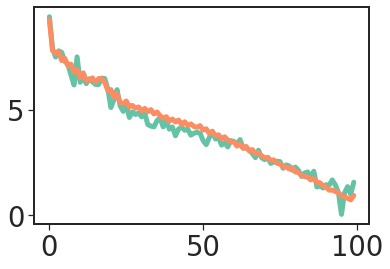

In [10]:
n_samples = 128
sampled = model_gmm_1comp.sample(n_samples=n_samples)

plt.plot(scaler.inverse_transform(sampled[0]).sum(axis=0)/n_samples)
plt.plot(features_blanks.sum(axis=0)/len(features_blanks))

Amount predicted tunneling: 1680


Generating 2D histograms: 100%|██████████| 1680/1680 [00:00<00:00, 3172.46it/s]


Amount predicted tunneling: 3114


Generating 2D histograms: 100%|██████████| 3114/3114 [00:00<00:00, 3543.63it/s]


Amount predicted tunneling: 3447


Generating 2D histograms: 100%|██████████| 3447/3447 [00:00<00:00, 3819.54it/s]


Amount predicted tunneling: 3243


Generating 2D histograms: 100%|██████████| 3243/3243 [00:00<00:00, 3869.08it/s]
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


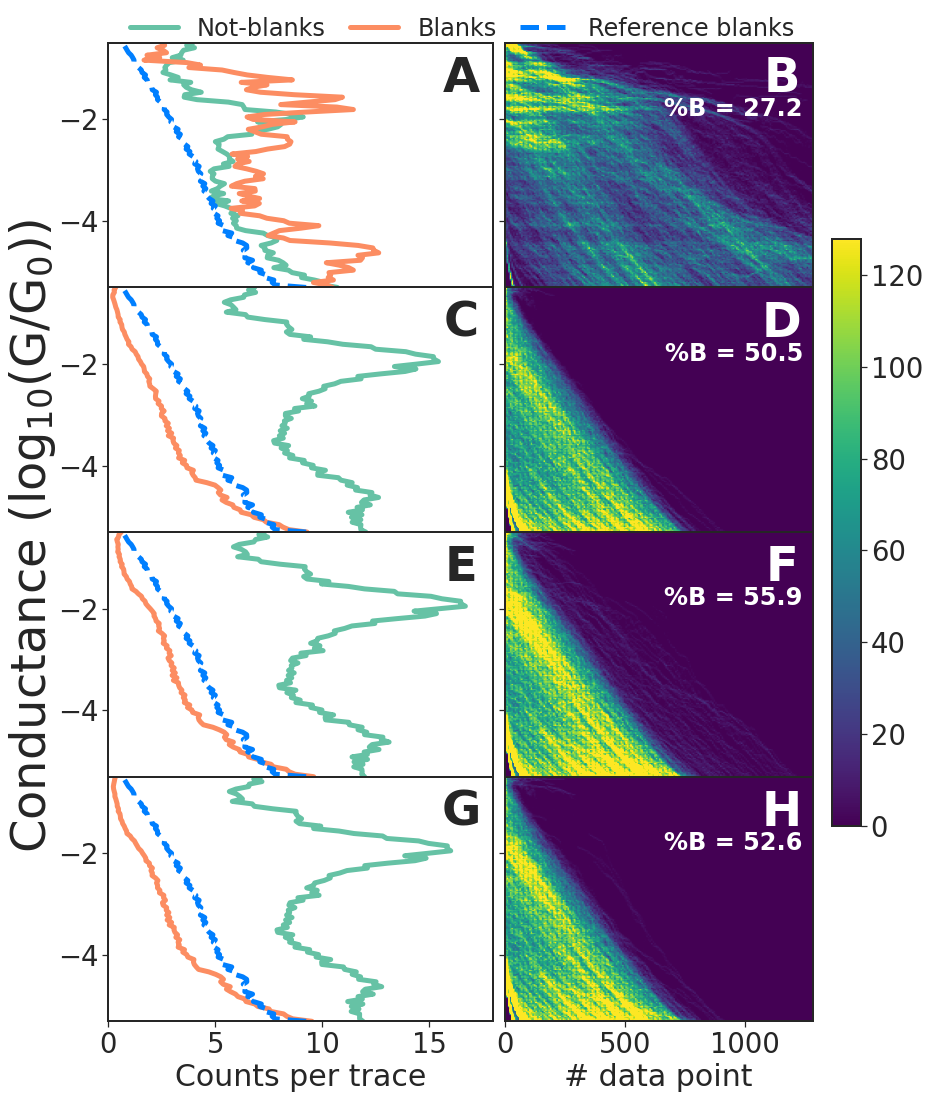

In [11]:
fig, ax = plt.subplots(len(models), 2, figsize=(14, 18))  # or 26
text_height = -1.2

ax1_yaxis = np.linspace(pre_info.plot_low, pre_info.plot_high, pre_info.bins)
max_ax1 = 0
percentages = []
for idx, (pred_labels, model) in enumerate(zip(predicted_labels, models)):
    if model.__class__.__name__ in ["AutoEncoder", "VAE", "DeepSVDD"]:
        pred_labels[pred_labels == 0] = -1
        pred_labels *= -1

    # linear ocsvm has switched the pred_labels
    if model.__class__.__name__ == "OneClassSVM":
        if model.get_params()["kernel"] == "linear":
            pred_labels *= -1

    pred_mol = plot_hist_molecular[pred_labels == -1]
    ax[idx, 0].plot(
        pred_mol.sum(axis=0)/len(pred_mol),
        ax1_yaxis,
        label=f"Not-blanks" if idx == 0 else ""
    )
    pred_tun = plot_hist_molecular[pred_labels == 1]
    ax[idx, 0].plot(
        pred_tun.sum(axis=0)/len(pred_tun),
        ax1_yaxis,
        label=f"Blanks" if idx == 0 else ""
    )
    print(f"Amount predicted tunneling: {len(pred_tun)}")
    percentages.append(1.0 - (len(plot_hist_molecular) - len(pred_tun))/len(plot_hist_molecular))

    ax[idx, 0].plot(
        plot_hist_blanks.sum(axis=0)/len(plot_hist_blanks),
        ax1_yaxis,
        c=c[0],
        linestyle="--",
        label="Reference blanks" if idx == 0 else "",
    )

    bins_2d = 128 + 64
    hist_2d = np.zeros((bins_2d, bins_2d))
    for trace in tqdm(fullwindow_molecular[pred_labels == 1], desc="Generating 2D histograms"):
        H, *_ = np.histogram2d(
            trace, np.arange(len(trace)), bins=bins_2d, range=[[pre_info.plot_low, pre_info.plot_high], [0, hist2d_length]]
        )
        hist_2d += H

    im = ax[idx, 1].imshow(
        hist_2d,
        vmin=0,
        vmax=128,
        origin="lower",
        cmap="viridis",
        extent=[0, hist2d_length, pre_info.plot_low, pre_info.plot_high],
        aspect="auto",
    )
    ax[idx, 1].text(
        hist2d_length - 128, text_height, ALPHABET[idx*2 + 1], va="center", ha="center", weight="bold", size=FONTSIZE, c="white"
    )
    
    if not idx == len(models) - 1:
        ax[idx, 0].set_xticklabels([])
        ax[idx, 1].set_xticklabels([])
    ax[idx, 1].set_yticklabels([])
    ax[idx, 0].set_ylim(pre_info.plot_low, pre_info.plot_high)
ax[0, 0].legend(frameon=False, loc="lower left", bbox_to_anchor=(0.0, 0.92, 1, 0), ncol=3, columnspacing=1., fontsize=FONTSIZE//2)

for idx, p in enumerate(percentages):
    # ax[idx, 0].text(11.5e4, text_height, ALPHABET[idx], va="center", ha="center", fontsize=FONTSIZE, weight="bold")
    ax[idx, 0].text(16.5, text_height, ALPHABET[idx*2], va="center", ha="center", fontsize=FONTSIZE, weight="bold")
    ax[idx, 1].text(hist2d_length - 256 - 64 - 8, text_height - .6, f"%B = {p*100:.3}", va="center", ha="center", fontsize=FONTSIZE // 2, c="white", weight="bold")
    # ax[idx, 0].set_xlim(0, 12.5e4)
    ax[idx, 0].set_xlim(0, 18)

ax[-1, 0].set_xlabel("Counts per trace")
ax[-1, 1].set_xlabel("# data point")
# fig.text(0.5, 0.08, "# Data points", va="center", ha="center")
fig.text(0.05, 0.5, CONDUCTANCE_LABEL, va="center", ha="center", rotation="vertical", fontsize=FONTSIZE)
fig.subplots_adjust(hspace=0.0, wspace=0.03)
fig.colorbar(im, ax=ax[:, 1], shrink=.6)
plt.savefig("./visual_perf.pdf")
plt.show()

100%|██████████| 24/24 [00:00<00:00, 1633.45it/s]


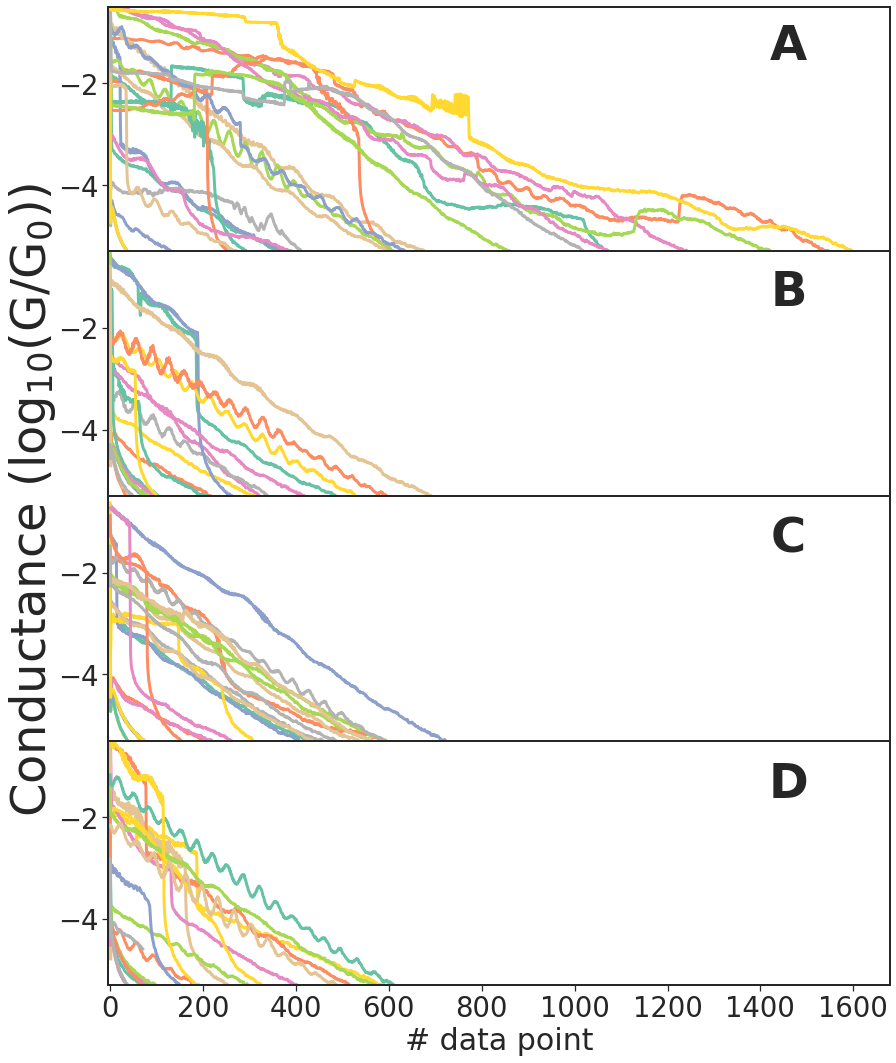

In [94]:
import matplotlib.cm as cmx
import matplotlib
cm_blues = plt.get_cmap("Blues")
cm_reds = plt.get_cmap("Reds")

bins_2d = 64
x, y = np.meshgrid(np.arange(0, bins_2d), np.arange(0, bins_2d))
fig, axes = plt.subplots(len(models), 1, figsize=(14, 18), sharex=True, sharey=True)
for idx, (ax, label_set) in enumerate(zip(axes, predicted_labels)):
    # cNorm = matplotlib.colors.Normalize(vmin=np.min(hist_2d), vmax=np.max(hist_2d)*.1)
    # scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm_blues)
    # hist_2d = generate_2dhistograms(fullwindow_molecular[label_set == 1], bins_2d=bins_2d, hist2d_length=hist2d_length)
    # hist_2d[hist_2d < 256] = 0
    # ax[0].scatter(x, y, s=hist_2d/10, c=scalarMap.to_rgba(hist_2d.ravel()), zorder=5, alpha=.5)
    
    # hist_2d = generate_2dhistograms(fullwindow_blanks, bins_2d=bins_2d, hist2d_length=hist2d_length)
    # hist_2d[hist_2d < 256] = 0
    # cNorm = matplotlib.colors.Normalize(vmin=np.min(hist_2d), vmax=np.max(hist_2d)*.1)
    # scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm_reds)
    # ax[0].scatter(x, y, s=hist_2d/10, c=scalarMap.to_rgba(hist_2d.ravel()), zorder=2)

    util_info.plot_individual_traces(p_molecular[label_set == 1], ax, size=24, rng=rng, pre_info)
    fig.text(0.8, .85 - idx*.19, ALPHABET[idx], weight="bold", size=FONTSIZE, va="center", ha="center")

plt.subplots_adjust(hspace=0.0)
plt.xlim(-4)
plt.ylim(pre_info.plot_low, pre_info.plot_high)
axes[-1].set_xlabel("# data point")
fig.text(0.05, 0.5, CONDUCTANCE_LABEL, ha="center", va="center", rotation="vertical", fontsize=FONTSIZE)
plt.savefig("predicted_tunneling_visualized.pdf")
plt.show()

100%|██████████| 1680/1680 [00:00<00:00, 4426.12it/s]
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


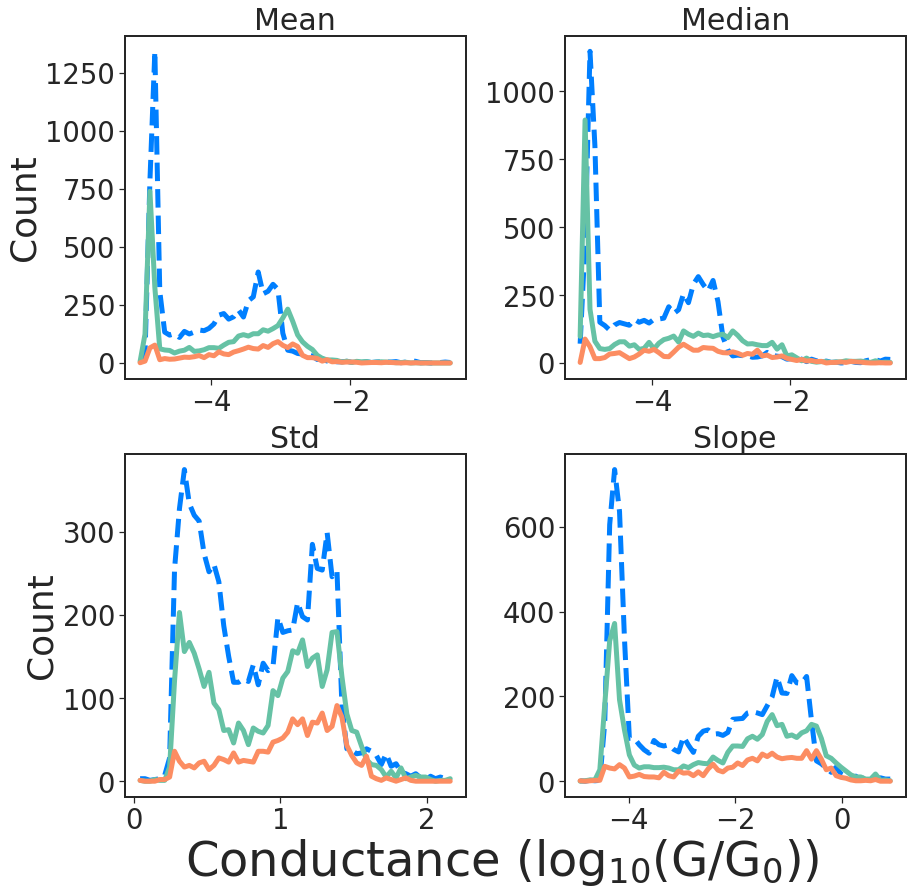

100%|██████████| 3053/3053 [00:00<00:00, 4209.02it/s]


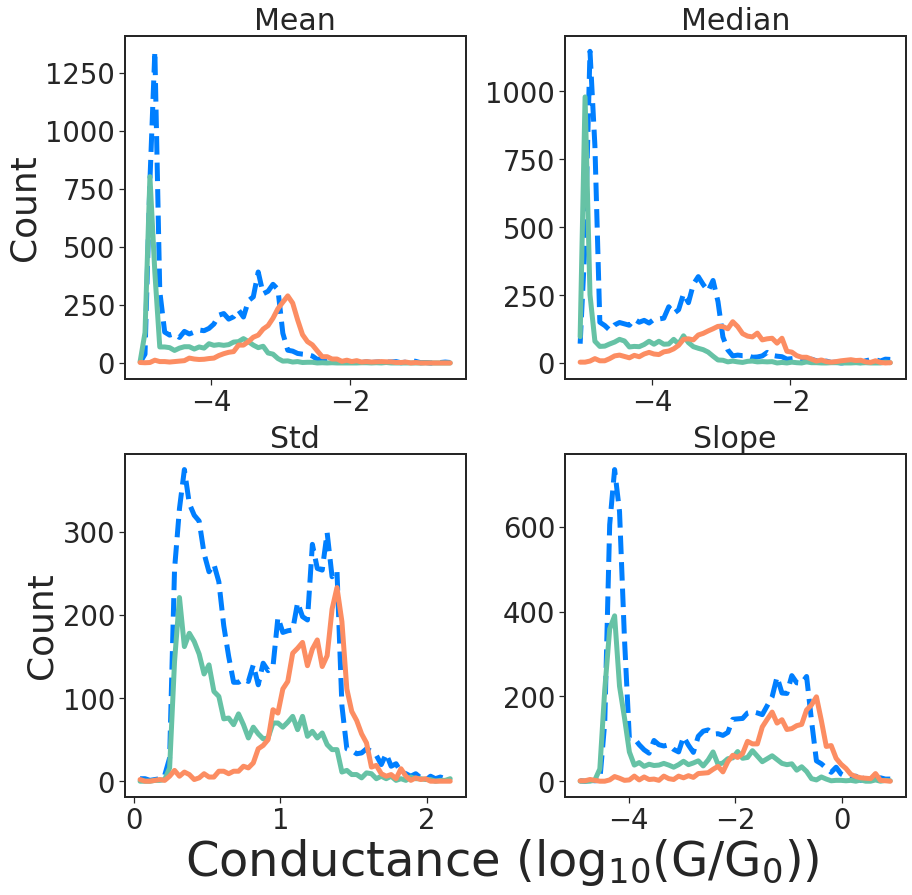

100%|██████████| 2720/2720 [00:00<00:00, 4115.83it/s]


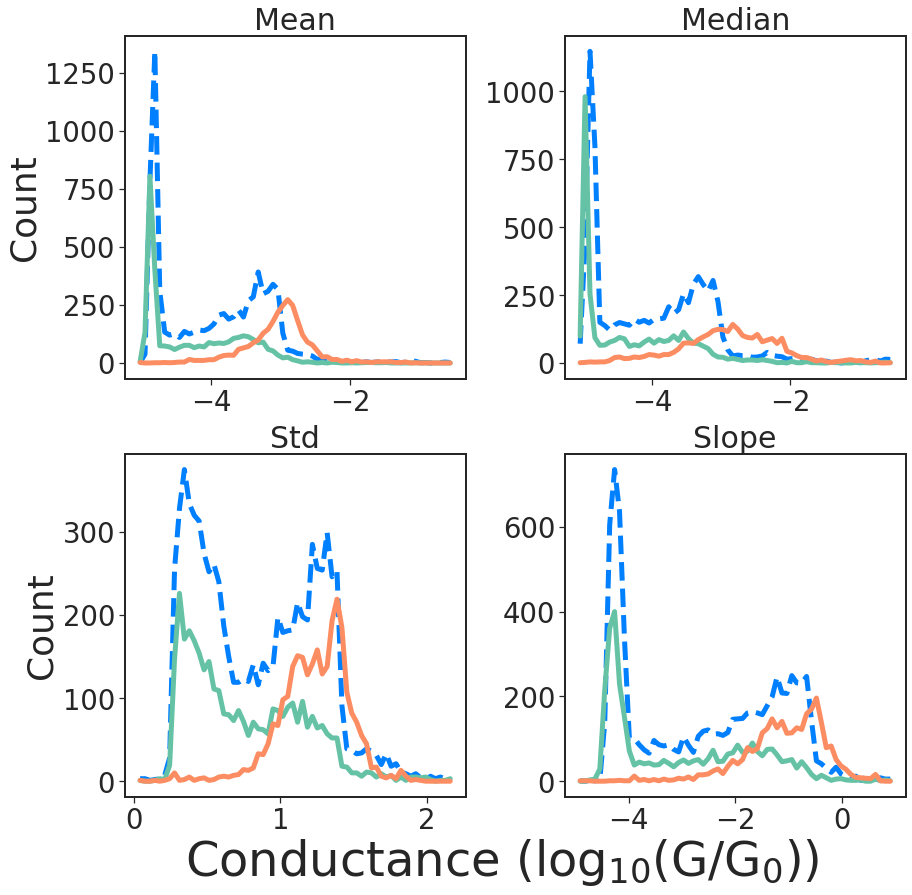

100%|██████████| 2924/2924 [00:00<00:00, 4317.44it/s]


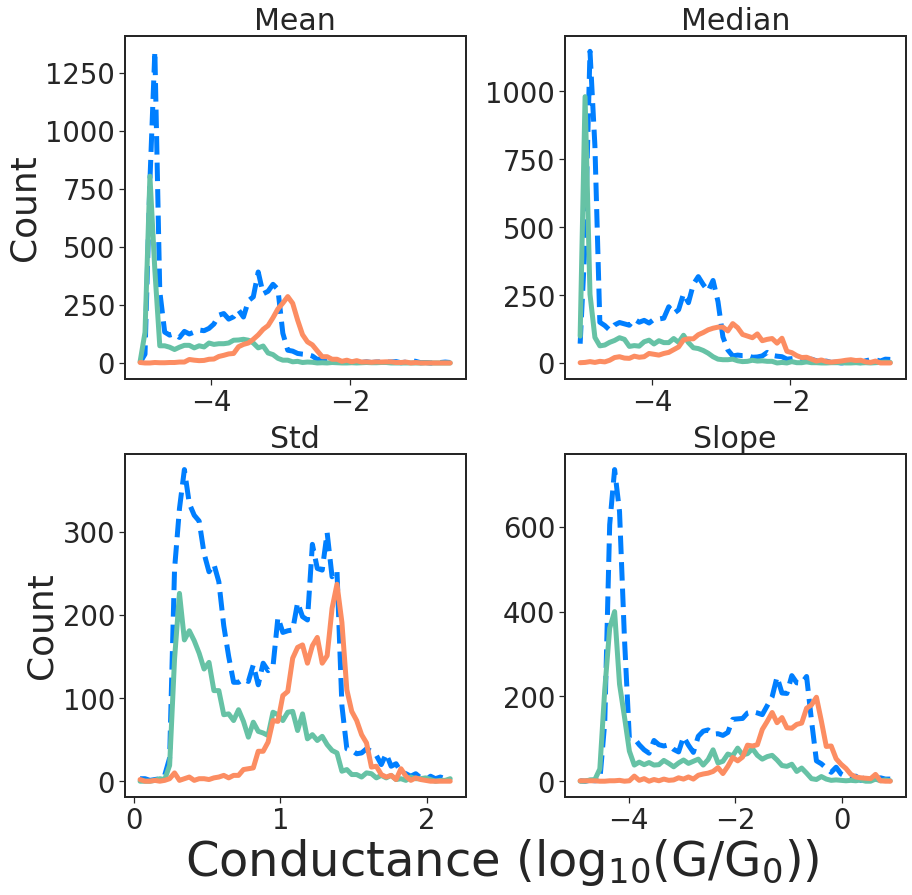

In [9]:
titles = [
    # "Length",
    "Mean",
    "Median",
    "Std",
    # "Offset",
    "Slope",
]
summary_blanks = util_functions.summary_statistics(p_blanks)
for j, label_set in enumerate(predicted_labels):
    summary_pred_blanks = util_functions.summary_statistics(p_molecular[label_set == 1])
    summary_pred_not = util_functions.summary_statistics(p_molecular[label_set == -1])
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    axes = axes.ravel()
    for i, title in enumerate(titles):
        min_range = np.min(summary_blanks[:, i])
        max_range = np.max(summary_blanks[:, i])
        hist, binedges = np.histogram(summary_blanks[:, i], bins=64, range=(min_range, max_range))
        binedges = (binedges[1:] + binedges[:-1])/2
        axes[i].plot(binedges, hist, label="Ref. blanks", linestyle="--", c=c[0])

        hist, binedges = np.histogram(summary_pred_blanks[:, i], bins=64, range=(min_range, max_range))
        binedges = (binedges[1:] + binedges[:-1])/2
        axes[i].plot(binedges, hist, label="Pred. blanks")

        hist, binedges = np.histogram(summary_pred_not[:, i], bins=64, range=(min_range, max_range))
        binedges = (binedges[1:] + binedges[:-1])/2
        axes[i].plot(binedges, hist, label="Pred. not-blanks")


        fs = 36
        if i % 2 == 0:
            axes[i].set_ylabel("Count", fontsize=fs)

        axes[i].set_title(title)
    fig.text(0.5, 0.06, CONDUCTANCE_LABEL, ha="center", va="center", fontsize=FONTSIZE)
    plt.subplots_adjust(hspace=.22, wspace=0.29)
    plt.savefig(f"summary_statistics_{j}")
    plt.show()

In [10]:
def colorbar(mappable, location: str):
  from mpl_toolkits.axes_grid1 import make_axes_locatable
  import matplotlib.pyplot as plt

  last_axes = plt.gca()
  ax = mappable.axes
  fig = ax.figure
  divider = make_axes_locatable(ax)
  cax = divider.append_axes(location, size="5%", pad=0.07)
  if location == "top":
    cbar = fig.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.ax.xaxis.set_ticks_position("top")
  else:
    cbar = fig.colorbar(mappable, cax=cax)
  cbar.ax.tick_params(labelsize=FONTSIZE//2)
  plt.sca(last_axes)
  return cbar


In [38]:
from scipy.optimize import curve_fit
def f(x, a, b, amplitude, omega, tau):
    return a*x + b #+ np.sin(x * omega + tau)*amplitude

init_a = -.01
init_b = 0
init_omega = 0.1
init_tau = np.pi/2
init_amplitude = 0.5

### Analyze molecular traces

set plot_high = 1 for the immediate next section to work properly

  0%|          | 0/3069 [00:00<?, ?it/s]/home/william/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 7909/7909 [00:03<00:00, 2079.69it/s]


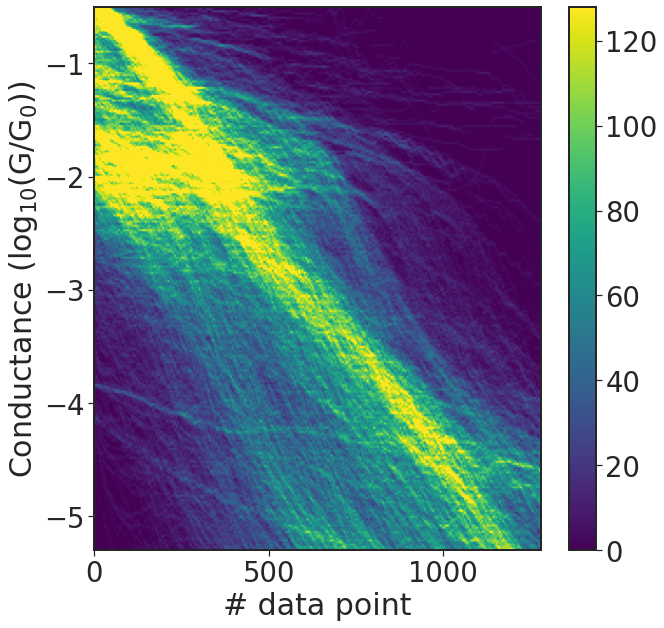

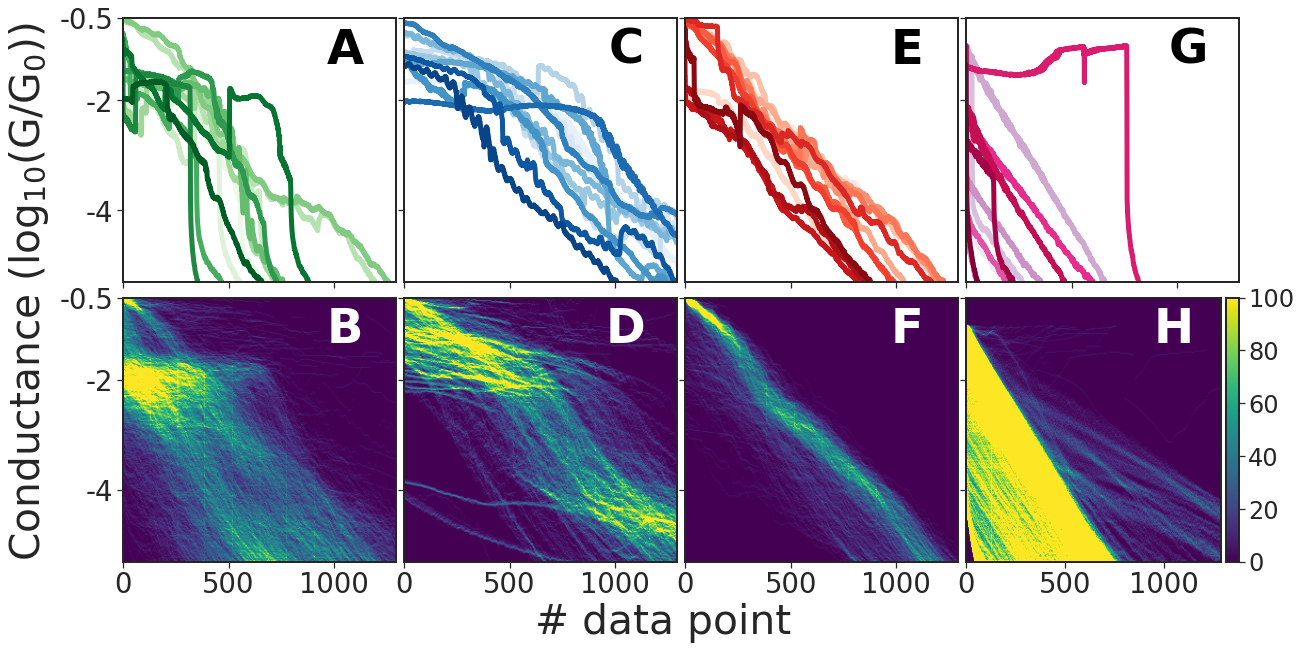

In [111]:
rng = np.random.default_rng(seed=2022)
fig, ax_total = plt.subplots(figsize=(10, 10))  # or 26
text_height = -1.08
selected_model = 1
window_top = -.5

ax1_yaxis = np.linspace(pre_info.plot_low, window_top, pre_info.bins)
max_ax1 = 0
percentages = []
bins_2d = (256, 256)
hist_2d = np.zeros(bins_2d)
for trace in tqdm(fullwindow_molecular[predicted_labels[selected_model] == -1], desc="Generating 2D histograms"):
    trace = trace[trace < window_top]
    trace = trace[trace > pre_info.plot_low]
    H, *_ = np.histogram2d(
        trace, np.arange(len(trace)), bins=bins_2d, range=[[pre_info.plot_low, window_top], [0, hist2d_length]]
    )
    hist_2d += H

im = ax_total.imshow(
    hist_2d,
    vmin=0,
    vmax=128,
    origin="lower",
    cmap="viridis",
    extent=[0, hist2d_length, pre_info.plot_low, window_top],
    aspect="auto",
)
# ax_total.text(
#     512 + 256 + 128 + 32, text_height, ALPHABET[idx*2 + 1], va="center", ha="center", weight="bold", size=FONTSIZE, c="white"
# )
# colorbar(im, location="top")
fig.colorbar(im, ax=ax_total)
ax_total.set_ylabel(CONDUCTANCE_LABEL)
ax_total.set_xlabel("# data point")

fig.savefig("./total_nt_2d.pdf")

fig, ax_traces = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(20, 10))
mol_2d, junk_2d, tunn_2d = np.zeros(bins_2d), np.zeros(bins_2d), np.zeros(bins_2d)
c_mol, c_junk, c_tunn = 0, 0, 0
example_amounts = 12
plot_length = 1290
blues = sns.color_palette("Blues", example_amounts)
reds = sns.color_palette("Reds", example_amounts)
greens = sns.color_palette("Greens", example_amounts)
shuffled_traces = fullwindow_molecular[predicted_labels[selected_model] == -1].copy()
rng.shuffle(shuffled_traces)
for t in tqdm(shuffled_traces[:-1]):
    t_windowed = t[t < window_top]
    H, *_ = np.histogram2d(t_windowed, np.arange(len(t_windowed)), bins=bins_2d, range=[[pre_info.plot_low, window_top], [0, plot_length]])

    if len(t[t > 0]) < 4:
        if c_junk < example_amounts:
            ax_traces[0, 1].plot(t_windowed, c=blues[c_junk])
            c_junk += 1
        junk_2d += H
    else:
        xdata = np.arange(len(t_windowed))
        try:
            popt, pcov = curve_fit(f, xdata, t_windowed, p0=[init_a, init_b, init_amplitude, init_omega, init_tau], maxfev=2048)
        except:
            print("skipping")
            continue
        if np.sum(np.abs(f(xdata, *popt) - t_windowed)) < 200 and len(t_windowed) > 800:
            if c_tunn < example_amounts:
                ax_traces[0, 2].plot(t_windowed, c=reds[c_tunn])
                c_tunn += 1
            tunn_2d += H
        else:
            if c_mol < example_amounts:
                ax_traces[0, 0].plot(t_windowed, c=greens[c_mol])
                c_mol += 1

            # _, c = plt.subplots()
            # c.plot(t_windowed, c="k", lw=1)
            # c.plot(xdata, f(xdata, *popt), linestyle="--", lw=1)
            # plt.show()

            # count += 1
            # if count == 32:
            #     break
            mol_2d += H
ax_traces[0, 2].set_xlim(0, plot_length)
ax_traces[0, 2].set_ylim(pre_info.plot_low, window_top)

ax_traces[1, 0].imshow(mol_2d, origin="lower", vmin=0, vmax=100, cmap="viridis", extent=[0, plot_length, pre_info.plot_low, window_top], aspect="auto")
ax_traces[1, 1].imshow(junk_2d, origin="lower", vmin=0, vmax=64, cmap="viridis", extent=[0, plot_length, pre_info.plot_low, window_top], aspect="auto")
ax_traces[1, 2].imshow(tunn_2d, origin="lower", vmin=0, vmax=100, cmap="viridis", extent=[0, plot_length, pre_info.plot_low, window_top], aspect="auto")


pinks = sns.color_palette("PuRd", example_amounts)
blanks_2d = np.zeros(bins_2d)
c_ref = 0
shuffled_blanks = p_blanks.copy()
rng.shuffle(shuffled_blanks)
for t in tqdm(shuffled_blanks):
    t_windowed = t[t < window_top]
    H, *_ = np.histogram2d(t_windowed, np.arange(len(t_windowed)), bins=bins_2d, range=[[pre_info.plot_low, window_top], [0, plot_length]])
    blanks_2d += H
    if c_ref < example_amounts:
        ax_traces[0, 3].plot(t_windowed, c=pinks[c_ref])
        c_ref += 1
im = ax_traces[1, 3].imshow(blanks_2d, origin="lower", vmin=0, vmax=100, cmap="viridis", extent=[0, plot_length, pre_info.plot_low, window_top], aspect="auto")

for idx, a in enumerate(ax_traces.T.ravel()):
    # ax[idx, 0].text(11.5e4, text_height, ALPHABET[idx], va="center", ha="center", fontsize=FONTSIZE, weight="bold")
    color = "white"
    if idx % 2 == 0:
        color = "k"
    a.text(1050, text_height, ALPHABET[idx], va="center", ha="center", fontsize=FONTSIZE, weight="bold", c=color)
    # a.text(1000, text_height, ALPHABET[idx + 1], va="center", ha="center", fontsize=FONTSIZE, weight="bold", c="white")

ax_traces[1, 0].set_yticks([-0.5, -2, -4], [-0.5, -2, -4])
fig.text(0.07, 0.5, CONDUCTANCE_LABEL, va="center", ha="center", rotation="vertical", fontsize=FONTSIZE*0.85)
fig.text(0.5, 0.04, "# data point", va="center", ha="center", fontsize=FONTSIZE*0.85)
fig.subplots_adjust(hspace=0.06, wspace=0.03)
colorbar(im, location="right")
plt.savefig("./comparison_not_tunneling.pdf")
plt.show()

In [25]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
clusters = 6
kmeans = KMeans(n_clusters=clusters)
gmm = GaussianMixture(n_components=clusters)

kmeans_labels = kmeans.fit_predict(features_molecular)
gmm_labels = gmm.fit_predict(features_molecular)

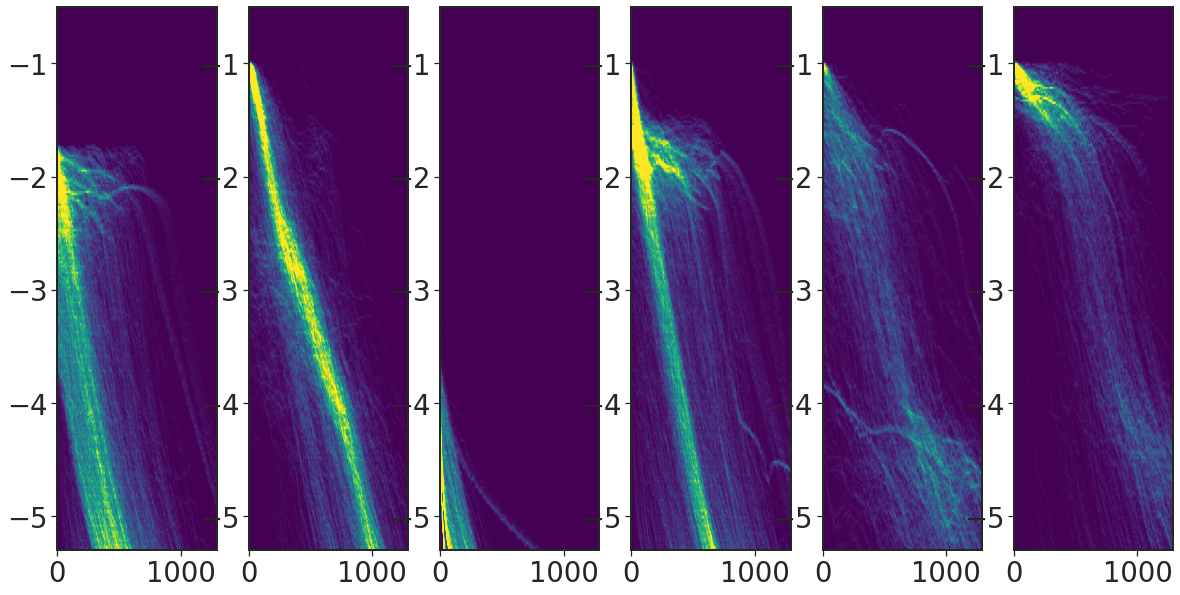

In [27]:
set2 = sns.color_palette("Set2", clusters)
plot_length = 1290
bins_2d = (256, 256)
fig, axes = plt.subplots(1, clusters, figsize=(20, 10))
for l in np.unique(kmeans_labels):
    tot_H = np.zeros(bins_2d)
    for t in p_molecular[gmm_labels == l]:
        H, *_ = np.histogram2d(t, np.arange(len(t)), bins=bins_2d, range=[[pre_info.plot_low, -.5], [0, plot_length]])
        tot_H += H
    axes[l].imshow(tot_H, origin="lower", vmin=0, vmax=100, cmap="viridis", extent=[0, plot_length, pre_info.plot_low, -.5], aspect="auto")
plt.show()

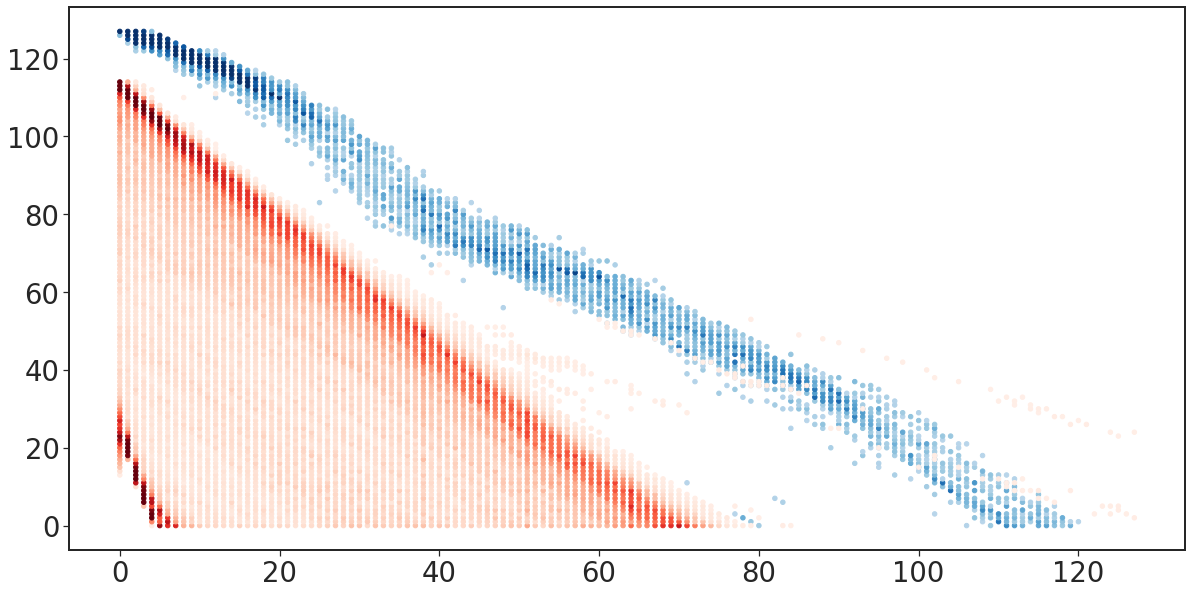

In [104]:
x, y = np.meshgrid(np.arange(0, 128), np.arange(0, 128))

fig, ax = plt.subplots(figsize=(20, 10))

new_tunn = tunn_2d.copy()
new_tunn[new_tunn < 30] *= 0
new_blank = blanks_2d.copy()
new_blank[new_blank < 30] *= 0

import matplotlib.cm as cmx
import matplotlib
cm = plt.get_cmap("Blues")
cNorm = matplotlib.colors.Normalize(vmin=np.min(new_tunn[::2, ::2]), vmax=np.max(new_tunn[::2, ::2])*.25)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
ax.scatter(x, y, s=(new_tunn[::2, ::2] > 0)*20, c=scalarMap.to_rgba(new_tunn[::2, ::2].ravel()))

cm = plt.get_cmap("Reds")
cNorm = matplotlib.colors.Normalize(vmin=np.min(new_blank[::2, ::2]), vmax=np.max(new_blank[::2, ::2])*.25)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
ax.scatter(x, y, s=(new_blank[::2, ::2] > 0)*20, c=scalarMap.to_rgba(new_blank[::2, ::2].ravel()), zorder=2)

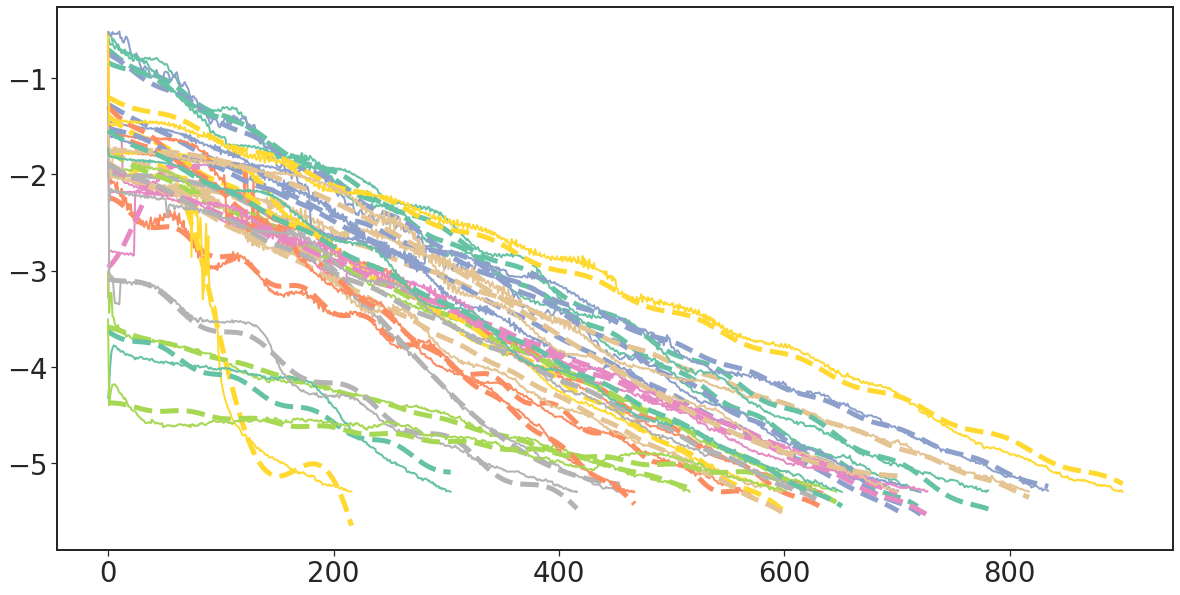

In [294]:
set2 = sns.color_palette("Set2", 8)
fig, ax = plt.subplots(figsize=(20, 10))
count = 0
for t in p_molecular[predicted_labels[1] == -1][:512]:
    if len(t[t > 0]) < 16:
        t = t[t< -.5]
        # plt.plot(t, c=c[1], lw=2)
    else:
        t = t[t< -.5]
        xdata = np.arange(len(t))
        # plt.plot(t, lw=2, c=set2[count % 8])
        # plt.plot(xdata, f(xdata, init_a, init_b, init_amplitude, init_omega, init_tau), linestyle="--", c=set2[count % 8])
        # plt.show()
        # foiwjeowifj

        popt, pcov = curve_fit(f, xdata, t, p0=[init_a, init_b, init_amplitude, init_omega, init_tau])
        if np.sum((f(xdata, *popt) - t)**2) < 10 and popt[3] > 0.001:
            plt.plot(t, lw=2, c=set2[count % 8])
            plt.plot(xdata, f(xdata, *popt), linestyle="--", c=set2[count % 8])
            count += 1

# for t in p_blanks[:6]:
#     t = t[t<-.5]
#     plt.plot(t, c=c[0], lw=2)
plt.show()

In [11]:
length_range = (0, 2048)
length_bins = 128

100%|██████████| 4/4 [00:00<00:00, 254.61it/s]


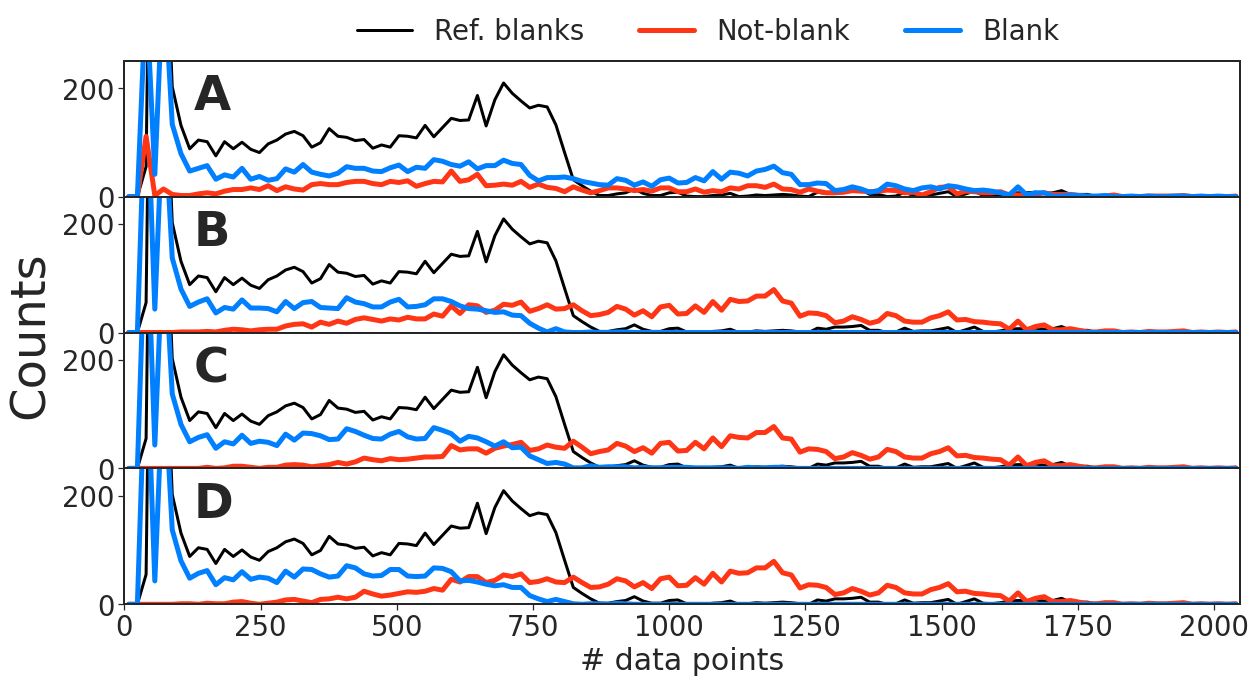

In [14]:
fig, ax = plt.subplots(4, 1, figsize=(20, 10), sharex=True, sharey=True)
pal = sns.color_palette("Set2", 12)
len_ref = np.histogram([len(x) for x in p_blanks], bins=length_bins, range=length_range)[0]
for idx, label_set in enumerate(tqdm(predicted_labels)):
    len_mol, binedges = np.histogram([len(x) for x in p_molecular[label_set == -1]], bins=length_bins, range=length_range)
    len_tun = np.histogram([len(x) for x in p_molecular[label_set == 1]], bins=length_bins, range=length_range)[0]

    binedges = (binedges[1:] + binedges[:-1])/2
    ax[idx].plot(binedges, len_ref, label="Ref. blanks", c="k", lw=3)
    ax[idx].plot(binedges, len_mol, label="Not-blank", c=c[1])
    ax[idx].plot(binedges, len_tun, label="Blank", c=c[0])
    # plt.plot(binedges, len_tun + len_mol, label="Total", c="k", linestyle="--", lw=4, alpha=0.8)
    ax[idx].text(128, 160, ALPHABET[idx], fontsize=FONTSIZE, weight="bold")
ax[0].legend(frameon=False, ncol=3, bbox_to_anchor=[1, 1, -0.14, 0.5])
plt.xlim(length_range)
plt.ylim(0, 250)
plt.xlabel("# data points")
fig.text(0.06, 0.5, "Counts", va="center", ha="center", rotation="vertical", fontsize=FONTSIZE)

fig.subplots_adjust(hspace=0.0)
fig.savefig("length_distributions.pdf")
plt.show()

In [5]:
cluster_labels = np.load("./cluster_labels_data_5.npy")
cluster_filtered_labels = np.load("./cluster_labels_filtered_data_5.npy")
oc_labels = np.load("./traditional_oc_labels.npy")

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


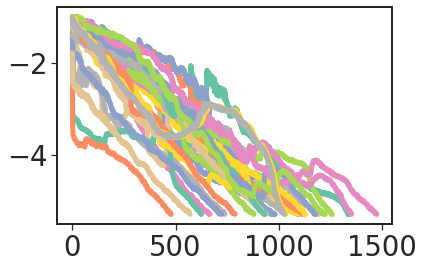

In [6]:
for t in p_molecular[cluster_labels[1] == 3][:32]:
    plt.plot(t)
plt.show()

In [15]:
def plot_cluster(sample_hists, blank_hists, labels, axes):
    max_ax1 = 0
    for idx, (m, ax) in enumerate(
        tqdm(
            zip(
                np.arange(len(labels)), axes.ravel()
            ),
            total=len(axes.ravel())
        )
    ):      
    
        ax.plot(
            ax1_yaxis,
            blank_hists.sum(axis=0),
            c=c[0],
            linestyle="--",
            label="Ref. blanks" if idx == 0 else "",
            alpha=0.8,
        )
        ax.plot(
            ax1_yaxis,
            sample_hists.sum(axis=0),
            c="k",
            linestyle="--",
            label="Ref. samples" if idx == 0 else "",
            alpha=0.8,
        )

        for label in np.unique(labels[m]):
            pred = sample_hists[labels[m] == label]
            ax.plot(
                ax1_yaxis,
                pred.sum(axis=0),
                label=f"{label + 1}" if idx == 0 else "",
            )
            # print(f"Amount of traces in {label + 1}: {len(pred)}")

            if np.max(pred.sum(axis=0)) > max_ax1:
                max_ax1 = np.max(pred.sum(axis=0))


        if np.max(sample_hists.sum(axis=0)) > max_ax1:
            max_ax1 = np.max(sample_hists.sum(axis=0))

        if np.max(blank_hists.sum(axis=0)) > max_ax1:
            max_ax1 = np.max(blank_hists.sum(axis=0))

        ax.set_xlim(pre_info.plot_low, pre_info.plot_high)

100%|██████████| 5/5 [00:00<00:00, 71.11it/s]


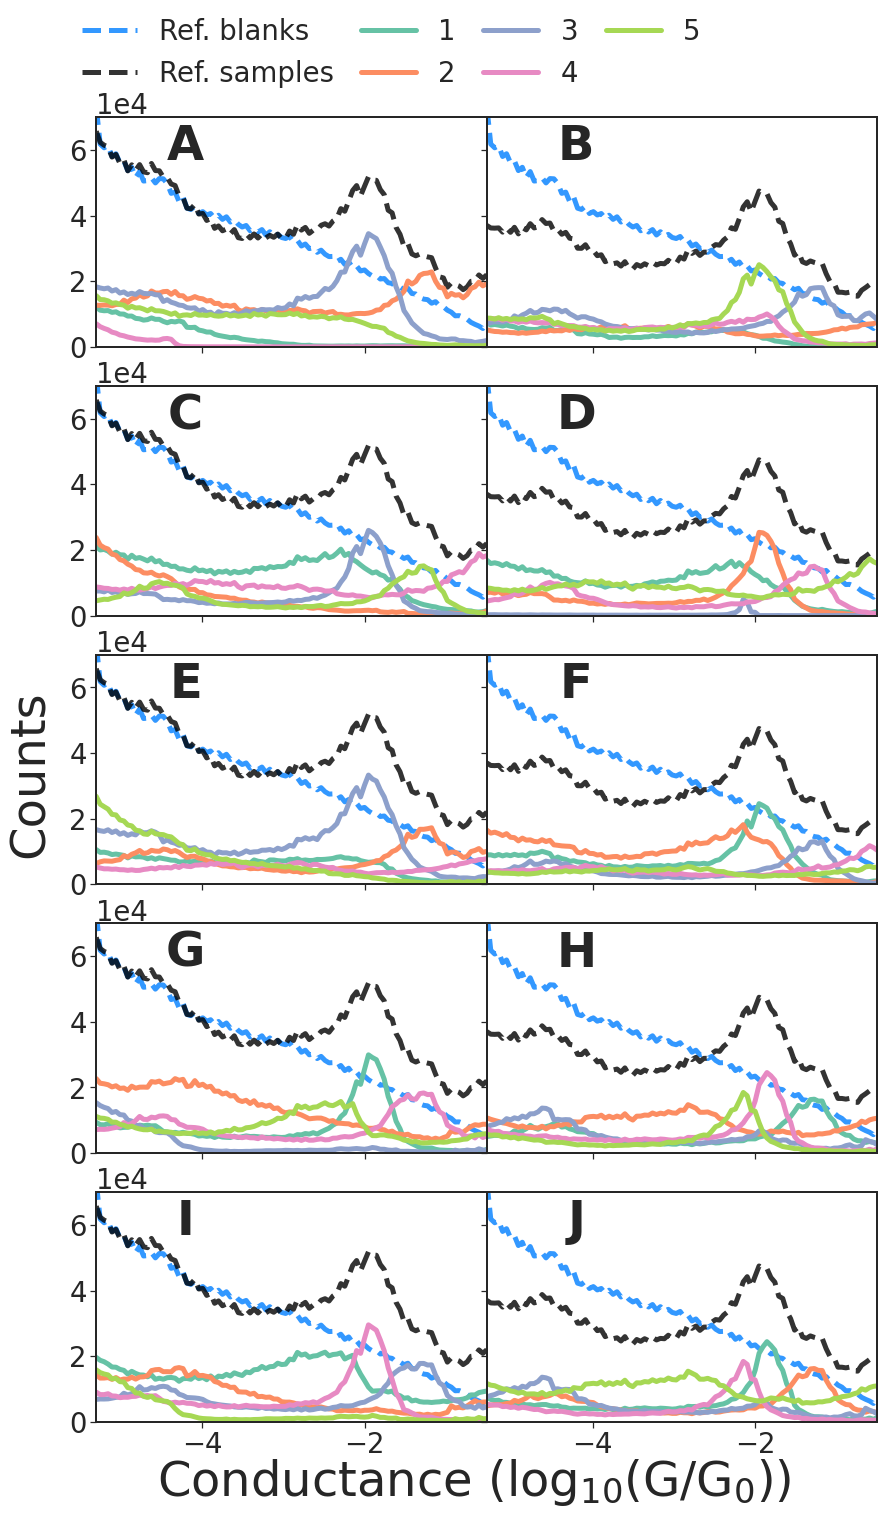

In [20]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 2, sharey=True, sharex=True, figsize=(14, 24))
fig.subplots_adjust(hspace=0.17, wspace=0.0)
ax1_yaxis = np.linspace(
    pre_info.plot_low, pre_info.plot_high, plot_hist_molecular.shape[1]
)
plot_cluster(plot_hist_molecular, plot_hist_blanks, cluster_labels, axes[:, 0])
plot_cluster(
    plot_hist_molecular[oc_labels[1] == -1],
    plot_hist_blanks,
    cluster_filtered_labels,
    axes[:, 1],
)

for idx, ax in enumerate(axes.ravel()):
    ax.text(
        -4.2,
        6.1e4,
        ALPHABET[idx],
        va="center",
        ha="center",
        weight="bold",
        fontsize=FONTSIZE
    )
    ax.set_ylim(0, 7e4)
    ax.ticklabel_format(axis="y", scilimits=[-5, 4])

fig.text(
    0.06,
    0.5,
    "Counts",
    va="center",
    ha="center",
    rotation="vertical",
    fontsize=FONTSIZE,
)
fig.text(0.5, 0.09, CONDUCTANCE_LABEL, va="center", ha="center", fontsize=FONTSIZE)
axes.ravel()[0].legend(
    frameon=False,
    loc="lower left",
    bbox_to_anchor=(-0.1, 1.02, 1, 0),
    ncol=4,
    columnspacing=1.0,
)
plt.savefig("./clustering_result.pdf")
plt.show()